In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

In [2]:
# Load the dataset
try:
    df = pd.read_csv('/kaggle/input/tickets-dataset/ticket_dataset.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'ticket_dataset.csv' not found. Please upload your dataset to the Colab environment.")
    raise

Data loaded successfully.


In [3]:
# Display initial information about the dataset
print("\n--- DataFrame Info ---")
df.info()

# Count the number of rows where both 'subject' and 'body' are missing
missing_both = df[(df['subject'].isnull()) & (df['body'].isnull())].shape[0]
print(f"\nRows with both 'subject' and 'body' missing: {missing_both}")


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11923 entries, 0 to 11922
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   10891 non-null  object
 1   body      11922 non-null  object
 2   answer    11920 non-null  object
 3   type      11923 non-null  object
 4   priority  11923 non-null  object
 5   language  11923 non-null  object
 6   tag_1     11923 non-null  object
 7   tag_2     11913 non-null  object
 8   tag_3     11879 non-null  object
 9   tag_4     11050 non-null  object
 10  tag_5     7885 non-null   object
 11  tag_6     4538 non-null   object
 12  tag_7     2565 non-null   object
 13  tag_8     1327 non-null   object
 14  queue     11923 non-null  object
dtypes: object(15)
memory usage: 1.4+ MB

Rows with both 'subject' and 'body' missing: 0


In [4]:
# Drop columns that won't be used for category prediction
columns_to_drop = ['type', 'language', 'answer', 'tag_1', 'tag_2', 'tag_3',
                   'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']

df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
print(f"Dropped columns: {columns_to_drop}")

Dropped columns: ['type', 'language', 'answer', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']


In [5]:
# Fill missing 'subject' and 'body' with empty strings
df['subject'].fillna('', inplace=True)
df['body'].fillna('', inplace=True)

# Combine 'subject' and 'body' into a new column for model input
df['full_text'] = df['subject'] + ' ' + df['body']

/tmp/ipykernel_36/1246845355.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['subject'].fillna('', inplace=True)
/tmp/ipykernel_36/1246845355.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

In [6]:
# Define a function to clean text data
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\.\S+', ' ', text)  # Remove URLs
    text = re.sub(r'\S+@\S+\.\S+', ' ', text)  # Remove email addresses
    text = re.sub(r'\b\d{10,13}\b', ' ', text)  # Remove phone numbers (simple pattern)
    text = re.sub(r'(\+\d{1,3})?[-.\s]??\(?\d+\)?[-.\s]??\d+[-.\s]??\d+', ' ', text)  # More phone patterns
    text = text.encode('ascii', 'ignore').decode()  # Remove non-ASCII characters
    text = re.sub(r"[^a-zA-Z0-9.,!?'\s]", ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

# Apply cleaning to the 'body' column (or 'full_text' if preferred)
df['body'] = df['body'].apply(clean_text)

In [7]:
# Check and remove duplicate rows
print(f"Duplicate rows before dropping: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Duplicate rows after dropping: {df.duplicated().sum()}")

Duplicate rows before dropping: 0
Duplicate rows after dropping: 0


In [8]:
# Create features for subject and full_text length
df['subject_length'] = df['subject'].apply(len)
df['text_length'] = df['full_text'].apply(len)

In [9]:
# Print number of unique values in key categorical columns
print(f"Unique values in 'queue': {df['queue'].nunique()}")
print(f"Unique values in 'priority': {df['priority'].nunique()}")

Unique values in 'queue': 5
Unique values in 'priority': 3


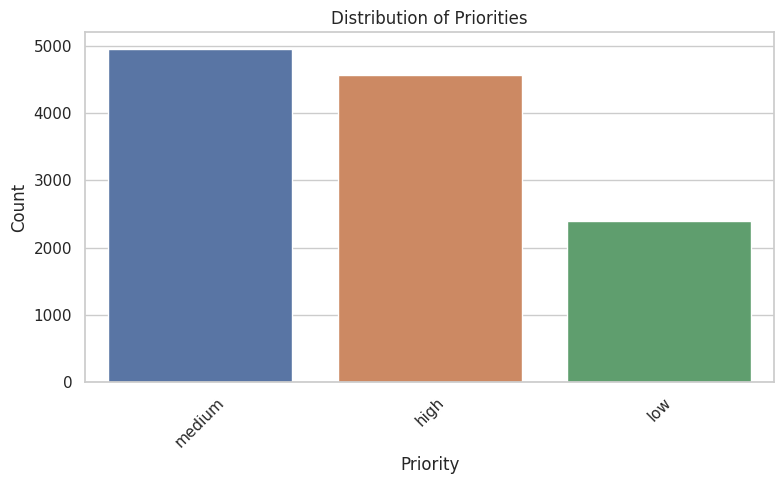

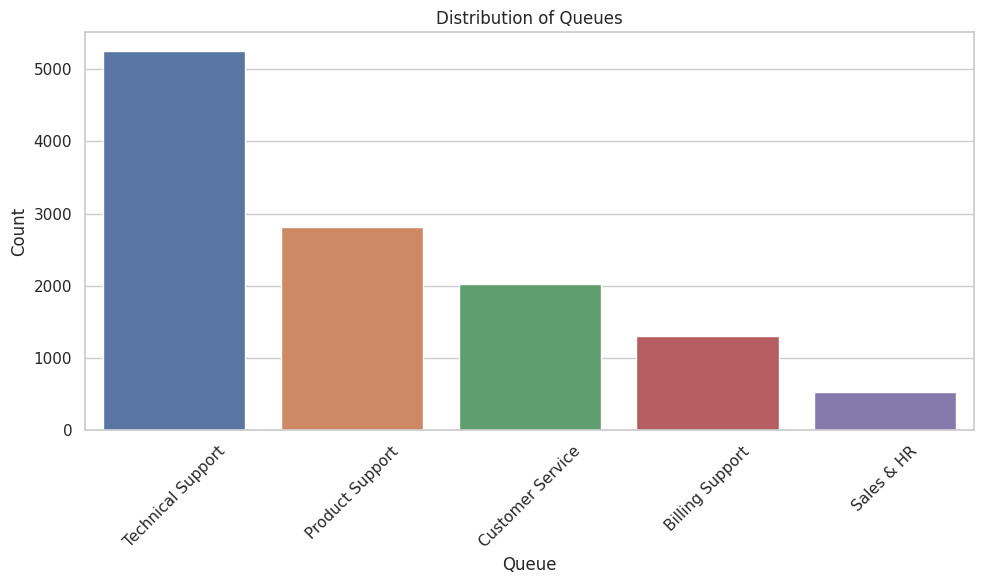

In [10]:
# Set seaborn style
sns.set(style='whitegrid')

# Plot distribution of 'priority'
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='priority', order=df['priority'].value_counts().index)
plt.title('Distribution of Priorities')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot distribution of top queues
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='queue', order=df['queue'].value_counts().index[:10])
plt.title('Distribution of Queues')
plt.xlabel('Queue')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


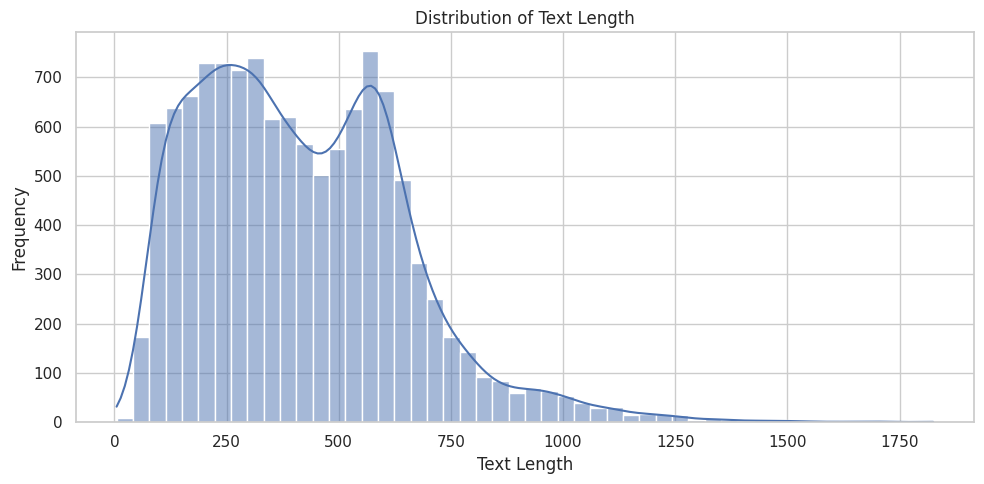

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


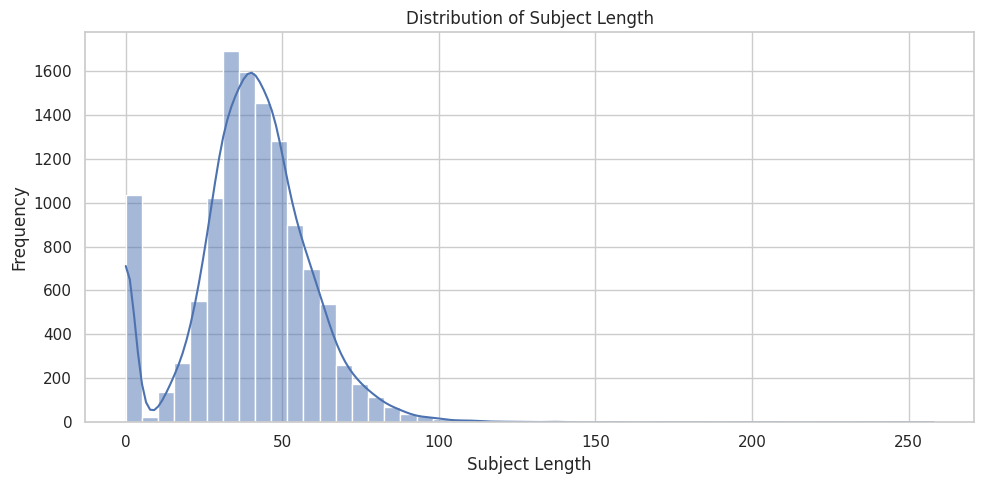

In [11]:
# Histogram of text lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Histogram of subject lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['subject_length'], bins=50, kde=True)
plt.title('Distribution of Subject Length')
plt.xlabel('Subject Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

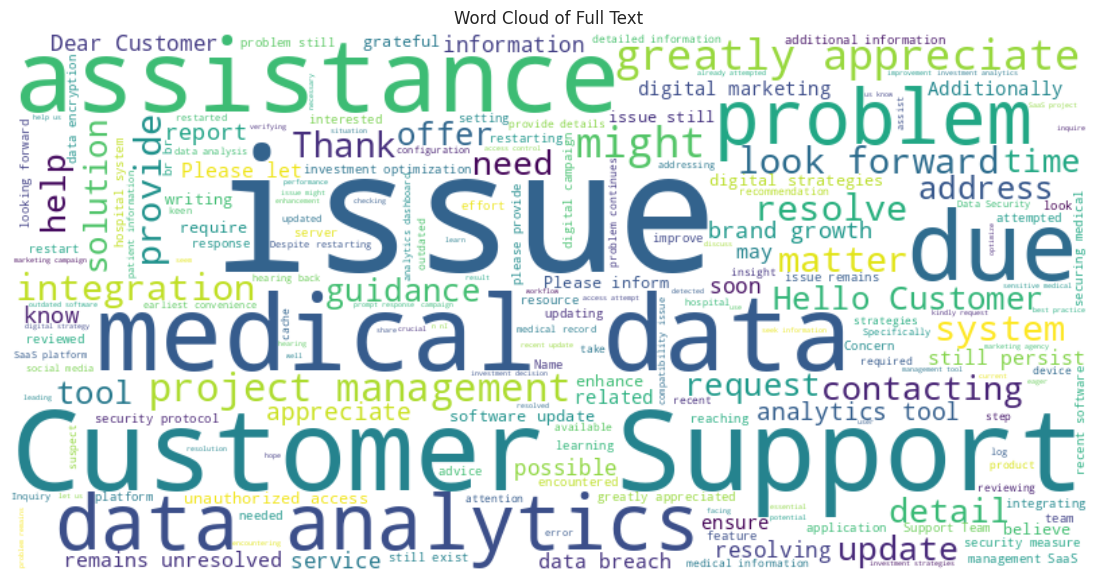

In [12]:
# Combine all full_text into a single string for word cloud
text = ' '.join(df['full_text'])

# Generate and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Full Text')
plt.show()

In [17]:
df.head()

,subject,body,priority,queue,full_text,subject_length,text_length
0,Customer Support Inquiry,seeking information on digital strategies that...,medium,Customer Service,Customer Support Inquiry Seeking information o...,24,250
1,Data Analytics for Investment,i am contacting you to request information on ...,medium,Customer Service,Data Analytics for Investment I am contacting ...,29,726
2,Security,"dear customer support, i am reaching out to in...",medium,Customer Service,"Security Dear Customer Support, I am reaching ...",8,684
3,Concerns About Securing Medical Data on 2-in-1...,inquiring about best practices for securing me...,medium,Technical Support,Concerns About Securing Medical Data on 2-in-1...,81,366
4,Problem with Integration,"the integration stopped working unexpectedly, ...",high,Technical Support,Problem with Integration The integration stopp...,24,329


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11923 entries, 0 to 11922
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subject         11923 non-null  object
 1   body            11923 non-null  object
 2   priority        11923 non-null  object
 3   queue           11923 non-null  object
 4   full_text       11923 non-null  object
 5   subject_length  11923 non-null  int64 
 6   text_length     11923 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 652.2+ KB


In [19]:
df.to_csv('processed_tickets.csv', index=False)